**This notebook is dedicated to my intership at CERIST**

---



Afin de garantir des résultats cohérants et fidèles au rapport, veillez ne pas exécuter le code dans la section **Données de synthèse** et de se contenter de télécharger le fichier csv disponible sur ce lien : https://drive.google.com/uc?export=download&id=1kqit8FS08pPWkSQrB4xdO0zSIp6_rNqd

Vous pouvez directement exécuter les cellules dans les sections qui suivent ( à savoir **Modèle de prédiction** et **Dashboard** )

# Données de synthèse


Statistiques descriptives :
       temperature_air_C  humidity_percent    co_percent  vibrations_g  \
count       20000.000000      20000.000000  20000.000000  20000.000000   
mean           32.031155         73.030882      0.029626      1.059353   
std             5.920006          2.131001      0.008125      1.124894   
min            18.000000         66.000000      0.010000      0.000044   
25%            27.979396         71.597008      0.023885      0.353356   
50%            31.989718         73.204959      0.028621      0.762726   
75%            36.036604         74.749325      0.034225      1.351897   
max            46.000000         76.000000      0.096294     10.000000   

       wind_speed_km_h     prob_risk   binary_risk  
count     20000.000000  20000.000000  20000.000000  
mean         17.643795      0.362845      0.250000  
std           9.198655      0.198769      0.433024  
min           0.160752      0.023485      0.000000  
25%          10.791771      0.202293   

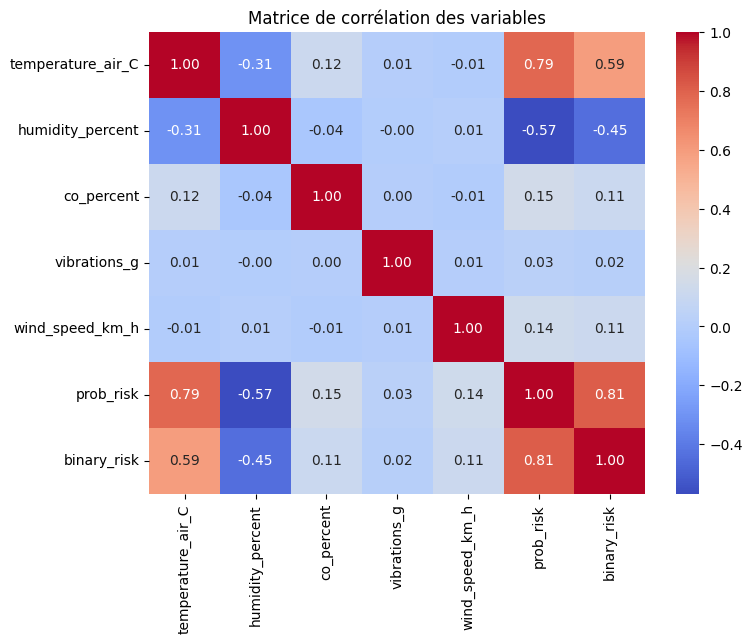

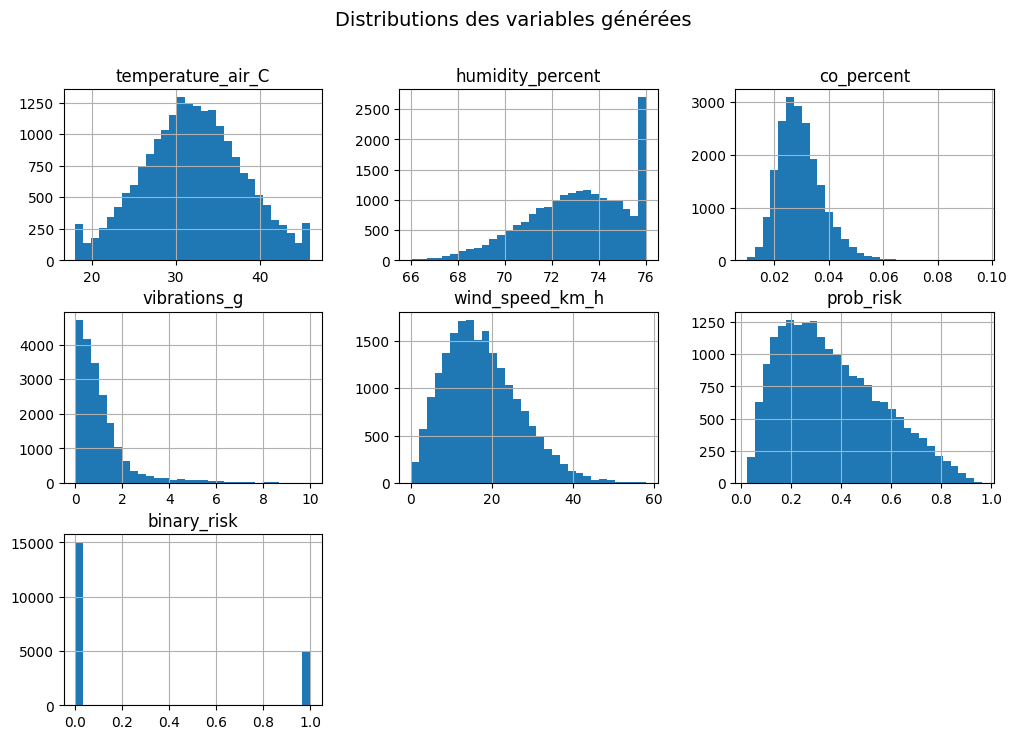

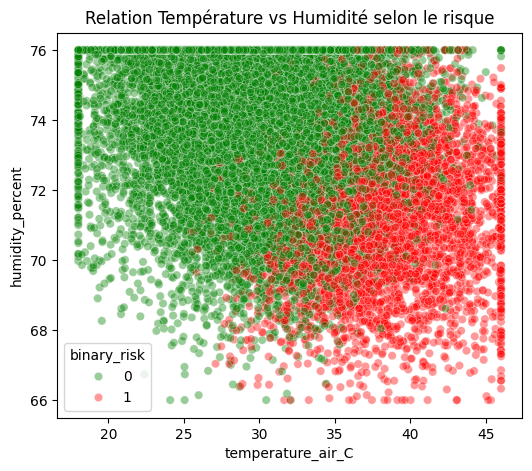

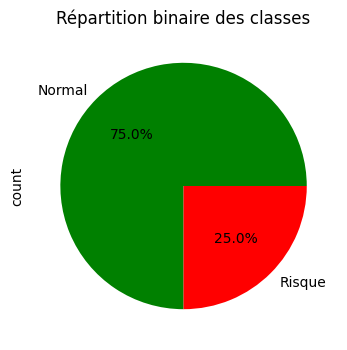

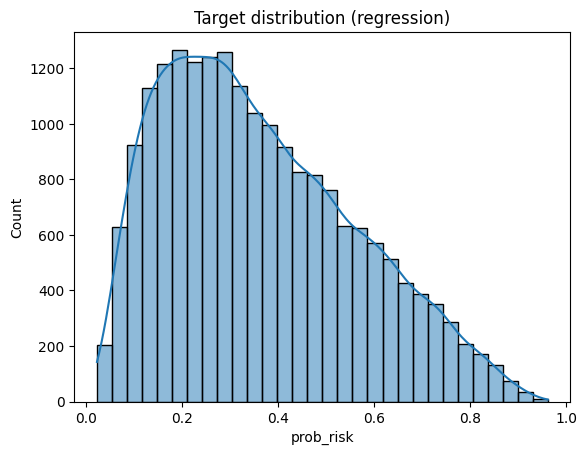

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Génération des données
# -------------------------

rng = np.random.default_rng(42)
n = 20000

######################################
# VARIABLE : Température (18 ~ 46 °C)
######################################

mu_T, sigma_T = 32, 6  # Moyenne autour de 32°C, écart-type 6°C
temperature = rng.normal(mu_T, sigma_T, n)
temperature = np.clip(temperature, 18, 46)

######################################
# VARIABLE : Humidité (66 ~ 76 %)
######################################

hum_base = rng.beta(5, 2, n) * (76 - 66) + 66
alpha = 0.35
temp_norm = (temperature - 18) / (46 - 18)  # normalisation sur [0,1]
hum_adj = hum_base - alpha * (temp_norm - temp_norm.mean()) * (76 - 66)
humidity = np.clip(hum_adj + rng.normal(0, 1.5, n), 66, 76)

######################################
# VARIABLE : CO (0.01 ~ 0.1 %)
######################################

co_base = np.exp(rng.normal(np.log(0.05), 0.3, n))
# distribution log-normale autour de 0.05 %
co_base = np.interp(co_base, (co_base.min(), co_base.max()), (0.01, 0.1))
co = co_base + 0.005 * (temp_norm - temp_norm.mean())  # corrélation légère avec T
co = np.clip(co + rng.normal(0, 0.002, n), 0.01, 0.1)

######################################
# VARIABLE : Vibrations (0 ~ 10 g)
######################################

p_spike = 0.15
is_spike = rng.random(n) < p_spike
vib = rng.normal(0, 1.0, n)  # fond calme
vib[is_spike] += rng.normal(0, 3.0, is_spike.sum())
vibrations = np.clip(np.abs(vib), 0, 10)

######################################
# VARIABLE : Vitesse du vent (0 ~ 58 km/h)
######################################

k = 2
lam = 20
wind_speed = np.random.weibull(k, n) * lam
wind_speed = np.clip(wind_speed, 0, 58)

######################################
# Normalisations utiles (pour prob_risk)
######################################

hum_low = 1 - (humidity - 66)/(76 - 66)
co_norm = (co - 0.01)/(0.1 - 0.01)
vib_norm = np.minimum(np.abs(vibrations)/10, 1.0)
wind_norm = wind_speed / 58

# Interaction T° × sécheresse : Idée réaliste : chaleur + sécheresse → le risque croît plus que linéairement (effet multiplicatif).
interaction = temp_norm * hum_low

# Combinaison réaliste
lin_score = (0.5 * temp_norm
             + 0.2 * hum_low
             + 0.15 * wind_norm
             + 0.15 * interaction
             + 0.10 * co_norm
             + 0.03 * vib_norm)


# Un peu de bruit pour éviter un problème trop simple
lin_score += rng.normal(0, 0.08, n)

# Mise en échelle logistique + calibration pour ~25%
from scipy.special import expit  # Applique une fonction sigmoid
z = (lin_score - np.median(lin_score)) / (lin_score.std() + 1e-9) # z : on centre et réduit lin_score → comparable à une variable standardisée.
t = np.percentile(z, 75)  # 75e centile => 25% au-dessus
prob_risk = expit(z - t)  # garantit ~25% avec proba > 0.5

######################################

####### VARIABLE : binary_risk

binary_risk = (prob_risk > 0.5).astype(int)

######################################

# Création du Dataframe
df = pd.DataFrame({
    "temperature_air_C": temperature,
    "humidity_percent": humidity,
    "co_percent": co,
    "vibrations_g": vibrations,
    "wind_speed_km_h": wind_speed,
    "prob_risk": prob_risk,
    "binary_risk": binary_risk
})

# Sauvegarde CSV
df.to_csv("synthetic_fire_risk.csv", index=False)

# -------------------------
# Validation statistique
# -------------------------
print("\nStatistiques descriptives :")
print(df.describe())

# Matrice de corrélation
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des variables")
plt.show()

# Distributions (Histogrammes() des variables
df.hist(bins=30, figsize=(12,8))
plt.suptitle("Distributions des variables générées", fontsize=14)
plt.show()

# Température vs Humidité avec couleur par risque
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="temperature_air_C",
    y="humidity_percent",
    hue="binary_risk",
    data=df,
    alpha=0.4,
    palette=["green", "red"]
)
plt.title("Relation Température vs Humidité selon le risque")
plt.show()

# Pourcentage de chaque classe de la variable binaire
plt.figure(figsize=(4,4))
df["binary_risk"].value_counts().plot.pie(
    autopct="%1.1f%%",
    labels=["Normal", "Risque"],
    colors=["green", "red"]
)
plt.title("Répartition binaire des classes")
plt.show()

# Distribution de la variable continue
sns.histplot(df['prob_risk'], bins=30, kde=True)
plt.title("Target distribution (regression)")
plt.show()

In [ ]:
df.head()

,temperature_air_C,humidity_percent,co_percent,vibrations_g,wind_speed_km_h,prob_risk,binary_risk
0,33.828302,69.534859,0.032907,1.013712,18.682751,0.682867,1
1,25.760095,70.678049,0.031033,0.283430,21.732372,0.265156,0
2,36.502707,71.560611,0.031857,0.951434,11.947670,0.406738,0
3,37.643388,73.569371,0.042006,0.666463,12.680361,0.575479,1
4,20.293789,72.929381,0.029848,1.263685,10.556844,0.070733,0


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, norm, spearmanr, pearsonr, t

# --------------------------------------------
# Assume you already have a DataFrame df with:
# ["temperature", "humidity", "co", "vibrations", "wind_speed"]
# --------------------------------------------

# -------- Method 2: Distribution Fitting (KS Test) --------
def ks_test_normal(data, var_name):
    mu, sigma = data.mean(), data.std()
    ks_stat, p_val = kstest(data, 'norm', args=(mu, sigma))
    return {"Variable": var_name, "KS stat": ks_stat, "p-value": p_val}

results_ks = []
for col in ["temperature_air_C", "humidity_percent", "co_percent", "vibrations_g", "wind_speed_km_h"]:
    results_ks.append(ks_test_normal(df[col], col))

df_ks = pd.DataFrame(results_ks)
print("\n=== KS Test for Normality ===")
print(df_ks)

# -------- Method 3: Correlation Analysis --------
corr_results = []
cols = ["temperature_air_C", "humidity_percent", "co_percent", "vibrations_g", "wind_speed_km_h"]

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        x, y = cols[i], cols[j]
        pearson_corr, _ = pearsonr(df[x], df[y])
        spearman_corr, _ = spearmanr(df[x], df[y])
        corr_results.append({
            "Var1": x,
            "Var2": y,
            "Pearson": pearson_corr,
            "Spearman": spearman_corr
        })

df_corr = pd.DataFrame(corr_results)
print("\n=== Pairwise Correlations ===")
print(df_corr)

# -------- Method 4: Confidence Intervals --------
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(len(data))
    h = sem * t.ppf((1 + confidence) / 2., len(data)-1)
    return mean, mean - h, mean + h

ci_results = []
for col in cols:
    mean, lower, upper = confidence_interval(df[col])
    ci_results.append({
        "Variable": col,
        "Mean": mean,
        "95% CI Lower": lower,
        "95% CI Upper": upper
    })

df_ci = pd.DataFrame(ci_results)
print("\n=== 95% Confidence Intervals ===")
print(df_ci)



=== KS Test for Normality ===
            Variable   KS stat        p-value
0  temperature_air_C  0.009147   6.995062e-02
1   humidity_percent  0.081765  9.253879e-117
2         co_percent  0.052250   6.778491e-48
3       vibrations_g  0.173174   0.000000e+00
4    wind_speed_km_h  0.051023   1.084612e-45

=== Pairwise Correlations ===
                Var1              Var2   Pearson  Spearman
0  temperature_air_C  humidity_percent -0.307913 -0.306043
1  temperature_air_C        co_percent  0.116911  0.122401
2  temperature_air_C      vibrations_g  0.006168  0.000862
3  temperature_air_C   wind_speed_km_h -0.010013 -0.010787
4   humidity_percent        co_percent -0.042795 -0.043703
5   humidity_percent      vibrations_g -0.001344 -0.000151
6   humidity_percent   wind_speed_km_h  0.008121  0.004796
7         co_percent      vibrations_g  0.003581  0.002550
8         co_percent   wind_speed_km_h -0.009381 -0.008665
9       vibrations_g   wind_speed_km_h  0.007044  0.016491

=== 95% Conf

In [ ]:
import pandas as pd

# Suppose que ton dataset est dans un DataFrame df
invalid_rows = []

for idx, row in df.iterrows():
    t = row['temperature_air_C']
    h = row['humidity_percent']
    co = row['co_percent']
    v = row['vibrations_g']
    w = row['wind_speed_km_h']
    p = row['prob_risk']
    br = row['binary_risk']

    errors = []

    # --- Hard constraints ---
    if not (18 <= t <= 46): errors.append("Température hors bornes")
    if not (66 <= h <= 76): errors.append("Humidité hors bornes")
    if not (0.01 <= co <= 0.1): errors.append("CO hors bornes")
    if not (0 <= v <= 10): errors.append("Vibrations hors bornes")
    if not (0 <= w <= 58): errors.append("Vent hors bornes")
    if p > 0.5 and br != 1:
      errors.append("Binary risque incorrect (devrait être 1)")
    elif p <= 0.5 and br != 0:
      errors.append("Binary risque incorrect (devrait être 0)")


    # --- Soft constraints ---
    if t > 40 and h > 75: errors.append("T élevée + H élevée incohérent")
    if co > 0.08 and w > 40: errors.append("CO élevé + Vent fort incohérent")
    if p < 0.1 and (t > 44 and h < 67 and co > 0.09 and w > 50):
        errors.append("Risque trop faible malgré conditions extrêmes")

    if errors:
        invalid_rows.append((idx, errors))

# Conversion en DataFrame pour inspection
invalid_df = pd.DataFrame(invalid_rows, columns=["Index", "Errors"])

print(f"Nombre total de lignes invalides : {len(invalid_df)}")
invalid_df.head(10)  # afficher quelques exemples


Nombre total de lignes invalides : 129


,Index,Errors
0,126,[T élevée + H élevée incohérent]
1,378,[T élevée + H élevée incohérent]
2,831,[T élevée + H élevée incohérent]
3,846,[T élevée + H élevée incohérent]
4,955,[T élevée + H élevée incohérent]
5,1194,[T élevée + H élevée incohérent]
6,1395,[T élevée + H élevée incohérent]
7,1779,[T élevée + H élevée incohérent]
8,1881,[T élevée + H élevée incohérent]
9,1973,[T élevée + H élevée incohérent]


In [ ]:
invalid_df['Errors'].value_counts()

,count
Errors,
[T élevée + H élevée incohérent],129


In [ ]:
# Supprimer les lignes incohérentes
df_clean = df.drop(invalid_df["Index"])

# Vérifier la taille après suppression
print("Taille avant :", len(df))
print("Taille après :", len(df_clean))

Taille avant : 20000
Taille après : 19871


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Charger tes données
# df = pd.read_csv("tes_donnees.csv")  # à adapter
# Ici je suppose que ton DataFrame est déjà nommé df

# Sélectionner les colonnes numériques à tester
features = ["temperature_air_C", "humidity_percent", "co_percent",
            "vibrations_g", "wind_speed_km_h"]

X = df[features]

# -------------------
# 1. Isolation Forest
# -------------------
iso = IsolationForest(contamination=0.01, random_state=42)
df["anomaly_isoforest"] = iso.fit_predict(X)
# (-1 = anomalie, 1 = normal)

# -------------------
# 2. One-Class SVM
# -------------------
ocsvm = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
df["anomaly_ocsvm"] = ocsvm.fit_predict(X)
# (-1 = anomalie, 1 = normal)

# -------------------
# 3. Local Outlier Factor (LOF)
# -------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
df["anomaly_lof"] = lof.fit_predict(X)
# (-1 = anomalie, 1 = normal)

# -------------------
# Résumé des anomalies
# -------------------
summary = pd.DataFrame({
    "Méthode": ["IsolationForest", "OneClassSVM", "LOF"],
    "Nb anomalies": [
        (df["anomaly_isoforest"] == -1).sum(),
        (df["anomaly_ocsvm"] == -1).sum(),
        (df["anomaly_lof"] == -1).sum()
    ]
})

print(summary)

# Exporter les lignes suspectes pour analyse
df_anomalies = df[(df["anomaly_isoforest"] == -1) |
                  (df["anomaly_ocsvm"] == -1) |
                  (df["anomaly_lof"] == -1)]

df_anomalies.to_csv("anomalies_detectees.csv", index=False)


           Méthode  Nb anomalies
0  IsolationForest           200
1      OneClassSVM           201
2              LOF           200


In [ ]:
df_clean.to_csv("synthetic_fire_risk_clean.csv", index=False)

# Modèle de prédiction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier

url = "https://drive.google.com/uc?export=download&id=1uOx3Tjgtnc3wJL9r-0M7UmdjO9OG8NHu"
df = pd.read_csv(url)

# Features and targets
X = df.drop(columns=["prob_risk", "binary_risk"])
y_reg = df["prob_risk"]      # Regression target
y_clf = df["binary_risk"]    # Classification target


**Classification model**

On doit d'abords faire un oversampling pour augmenter la proportion des lignes avec binary_risk = 1

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np

print("Original dataset shape:", Counter(y_clf))

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_clf)

print("Resampled dataset shape:", Counter(y_resampled))


Original dataset shape: Counter({0: 14922, 1: 4949})
Resampled dataset shape: Counter({1: 14922, 0: 14922})


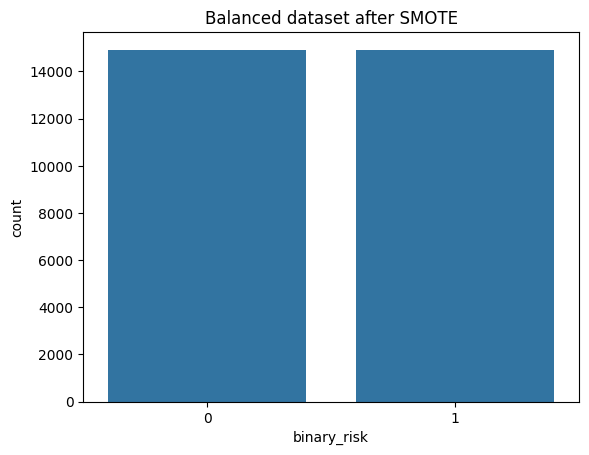

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.countplot(x=y_resampled)
plt.title("Balanced dataset after SMOTE")
plt.show()

Modèle de classification

In [ ]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoostClassifier": XGBClassifier(eval_metric="logloss", random_state=42)
}

print("\n=== Classification Models Evaluation ===")
for name, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n{name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}")



=== Classification Models Evaluation ===

LogisticRegression:
  Accuracy:  0.8596
  Precision: 0.8580
  Recall:    0.8620
  F1-score:  0.8600
  ROC-AUC:   0.9421

RandomForestClassifier:
  Accuracy:  0.9003
  Precision: 0.8855
  Recall:    0.9196
  F1-score:  0.9022
  ROC-AUC:   0.9648

GradientBoostingClassifier:
  Accuracy:  0.8668
  Precision: 0.8555
  Recall:    0.8827
  F1-score:  0.8689
  ROC-AUC:   0.9455

XGBoostClassifier:
  Accuracy:  0.8733
  Precision: 0.8603
  Recall:    0.8915
  F1-score:  0.8756
  ROC-AUC:   0.9499


Le Random Forest Classifier a le meilleur résultats donc on le garde


In [ ]:
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

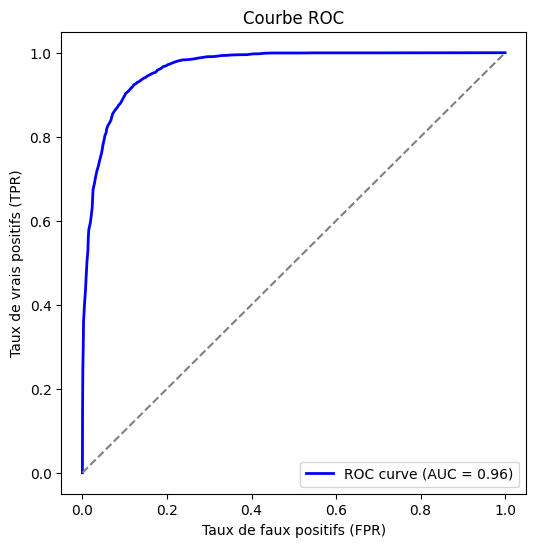

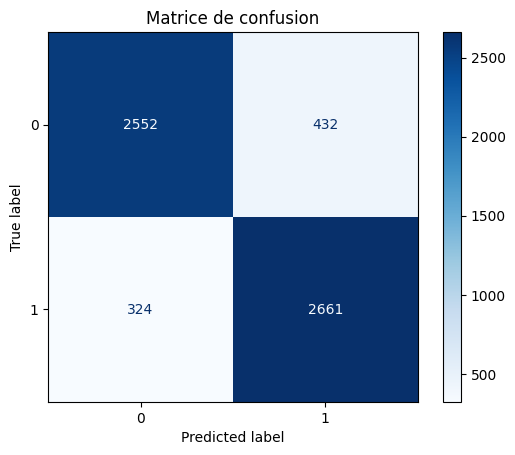

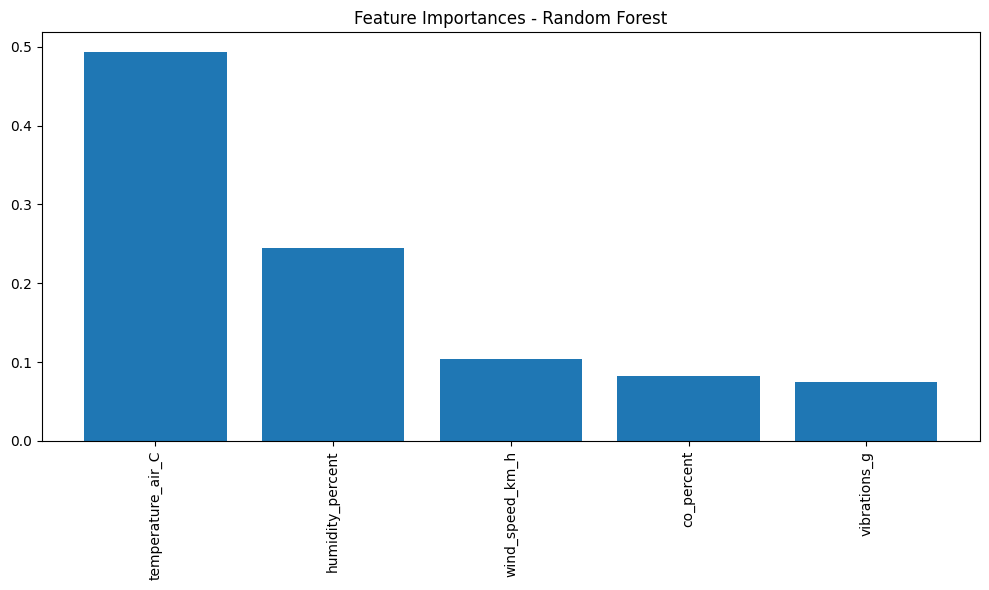

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
y_proba = final_model.predict_proba(X_test)[:, 1]  # proba que la classe = 1

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion")
plt.show()

# Features importance
importances = final_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(len(importances))
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

In [ ]:
import pickle

with open("classification_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

**Regression**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

regressors = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoostRegressor": XGBRegressor(
    colsample_bytree=0.9,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=3,
    n_estimators=800,
    subsample=0.7,
    random_state=42
) # J'ai utilisé le search grid pour trouver ces paramètres
}

print("=== Regression Models Evaluation ===")
for name, model in regressors.items():
    if name == "LinearRegression":
        model.fit(X_train_reg_scaled, y_train_reg)
        y_pred = model.predict(X_test_reg_scaled)
    else:
        model.fit(X_train_reg, y_train_reg)
        y_pred = model.predict(X_test_reg)

    mse = mean_squared_error(y_test_reg, y_pred)
    mae = mean_absolute_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)

    print(f"\n{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²:  {r2:.4f}")

=== Regression Models Evaluation ===

LinearRegression:
  MSE: 0.0093
  MAE: 0.0769
  R²:  0.7760

RandomForestRegressor:
  MSE: 0.0093
  MAE: 0.0752
  R²:  0.7756

GradientBoostingRegressor:
  MSE: 0.0087
  MAE: 0.0727
  R²:  0.7895

XGBoostRegressor:
  MSE: 0.0087
  MAE: 0.0726
  R²:  0.7905


Le XGBRegressor a les meilleurs résultats

In [ ]:
model_reg = XGBRegressor(
    colsample_bytree=0.9,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=3,
    n_estimators=800,
    subsample=0.7,
    random_state=42
)
model_reg.fit(X_train_reg_scaled, y_train_reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

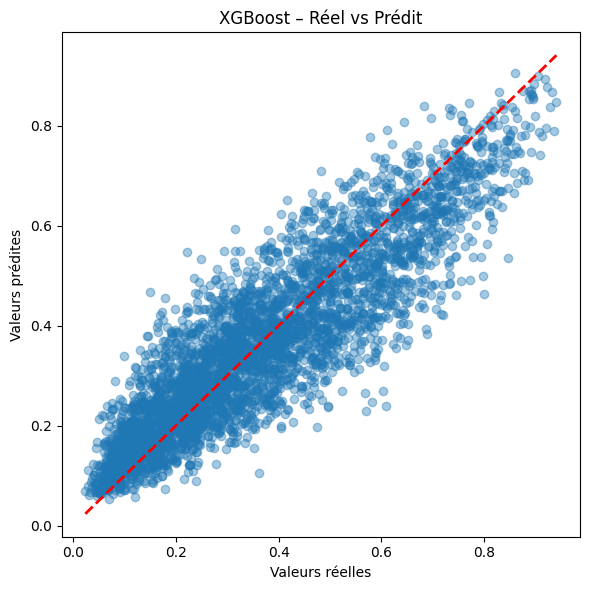

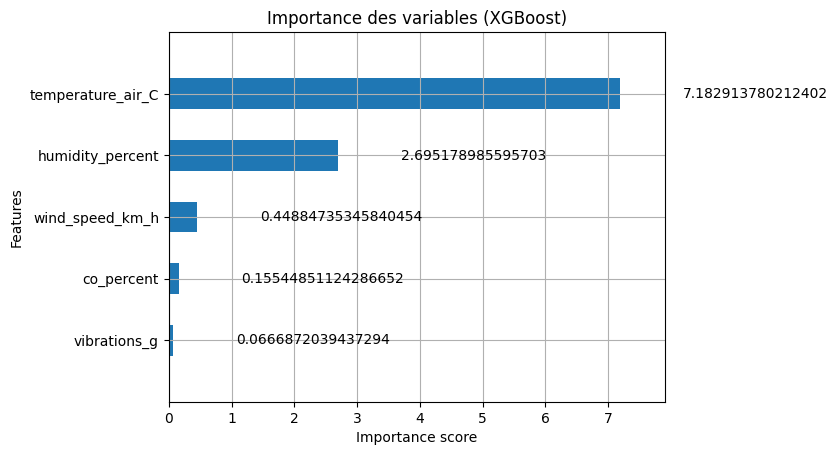

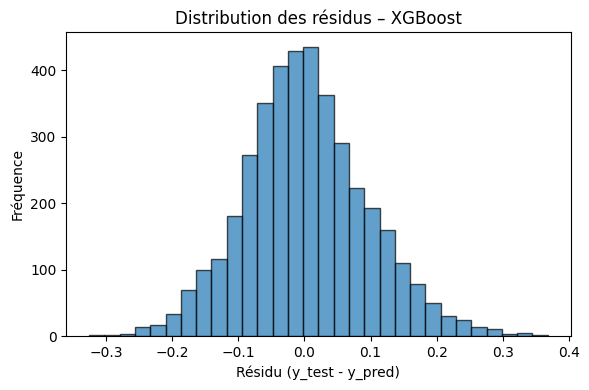

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Prédictions
y_pred = model_reg.predict(X_test_reg_scaled)

# Scatter Plot : Réel vs Prédit

plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred, alpha=0.4)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', lw=2)  # diagonale parfaite
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("XGBoost – Réel vs Prédit")
plt.tight_layout()
plt.show()

# Feature Importance

xgb.plot_importance(model, importance_type="gain", max_num_features=10, height=0.5)
plt.title("Importance des variables (XGBoost)")
plt.show()

# Histogramme des résidus

residuals = y_test_reg - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Résidu (y_test - y_pred)")
plt.ylabel("Fréquence")
plt.title("Distribution des résidus – XGBoost")
plt.tight_layout()
plt.show()


In [ ]:
import pickle

with open("regression_model.pkl", "wb") as f:
    pickle.dump(model_reg, f)

# Dashboard

In [ ]:
X_test.to_csv("testing_data.csv", index=False)

For the Dashboard code, you can find it in the github repository of the project among with the models files and testing data, training data and this notebook.

**Github repo Link :** https://github.com/dihiaflz/-Forest-Fire-Risk-Dashboard